In [1]:
import sys ###dppolicyagent
sys.path.append('../scripts/')
from puddle_world import *
import itertools
import collections

In [2]:
class DpPolicyAgent(PuddleIgnoreAgent):  ###dppolicyagent
    def __init__(self, time_interval, estimator, goal, puddle_coef=100, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): #widths以降はDynamicProgrammingから持ってくる
        super().__init__(time_interval, estimator, goal, puddle_coef) 
        
        ###座標関連の変数をDynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0] 
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        
        self.policy_data = self.init_policy(self.index_nums)
        
    def init_policy(self, index_nums):
        tmp = np.zeros(np.r_[index_nums,2])
        for line in open("policy.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
            
        return tmp
    
    def to_index(self, pose, pose_min, index_nums , widths): #姿勢をインデックスに変えて正規化
        index = np.floor((pose - pose_min)/widths).astype(int)           #姿勢からインデックスに
        
        index[2] = (index[2] + index_nums[2]*1000)%index_nums[2] #角度の正規化
        for i in [0,1]:                                                                                   #端の処理（内側の座標の方策を使う）
            if index[i] < 0: index[i] = 0
            elif index[i] >= index_nums[i]: index[i] = index_nums[i] - 1
                
        return tuple(index) #ベクトルのままだとインデックスに使えないのでタプルに
    
    def policy(self, pose, goal=None): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ                
        return self.policy_data[self.to_index(pose, self.pose_min, self.index_nums, self.widths)]

<IPython.core.display.Javascript object>


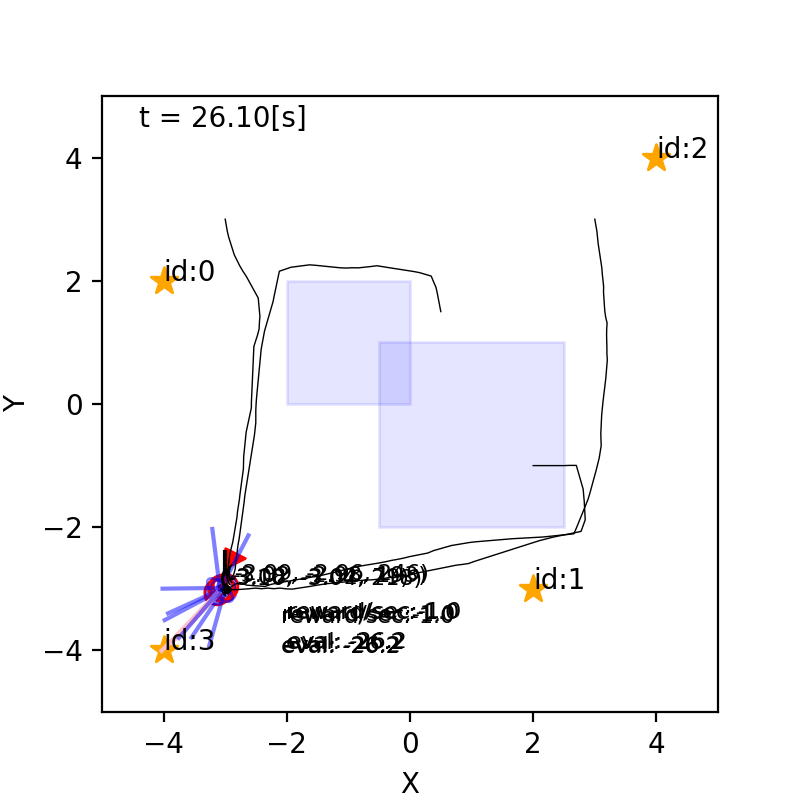

In [3]:
def trial():  ###dppolicyagentrun
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3)  #goalを変数に
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##4台のロボットを動かしてみる##   ##dppolicyagentrun
    init_poses = []
    for p in [[-3, 3, 0], [0.5, 1.5, 0], [3, 3, 0], [2, -1, 0]]:
        init_pose = np.array(p).T
    
        kf = KalmanFilter(m, init_pose)
        a = DpPolicyAgent(time_interval, kf, goal)
        r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))

        world.append(r)
        
    world.draw()
    
trial()